##### Flowchart

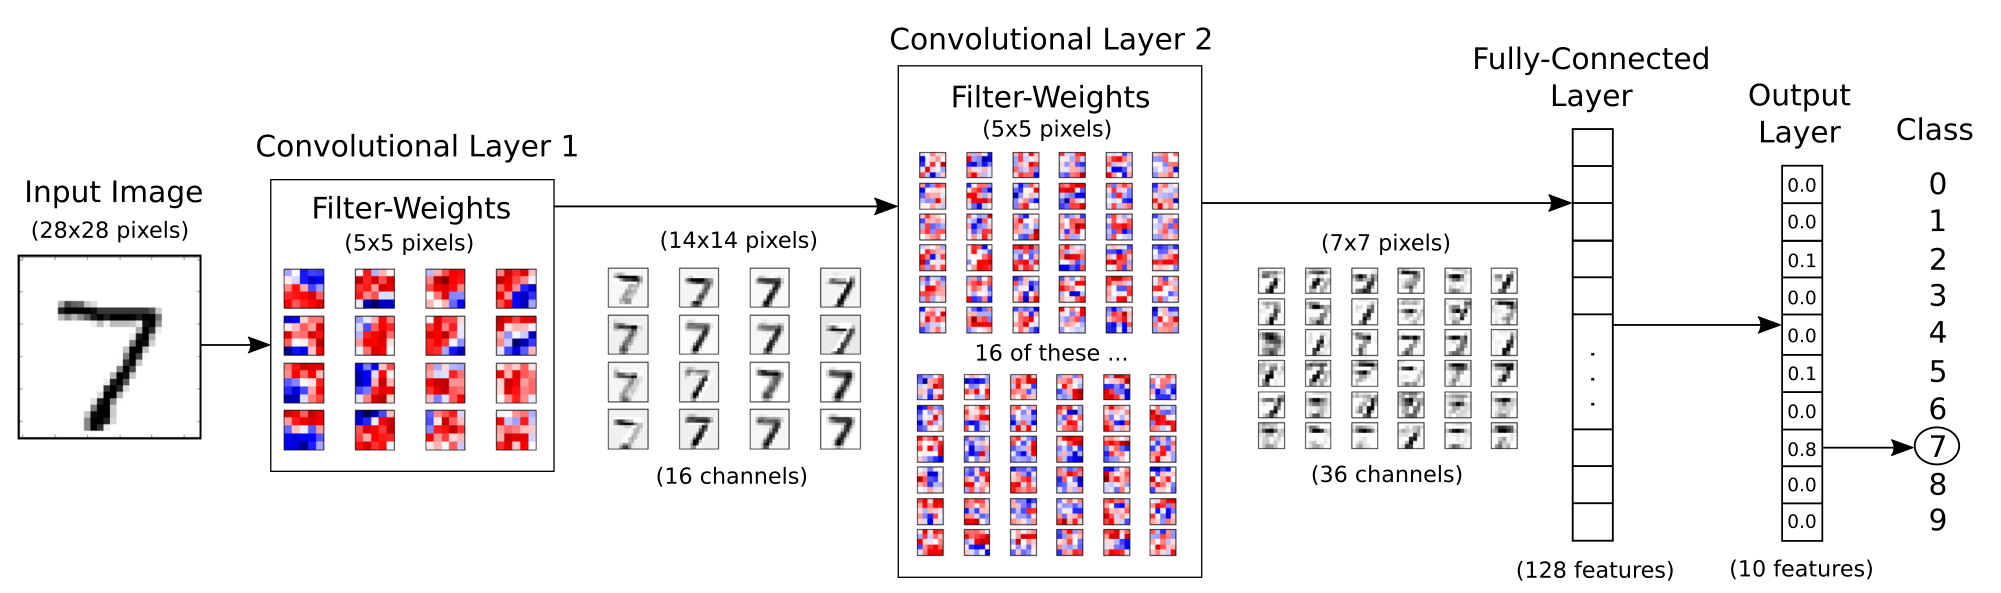

In [1]:
from IPython.display import Image
Image('figs/02_network_flowchart.png')

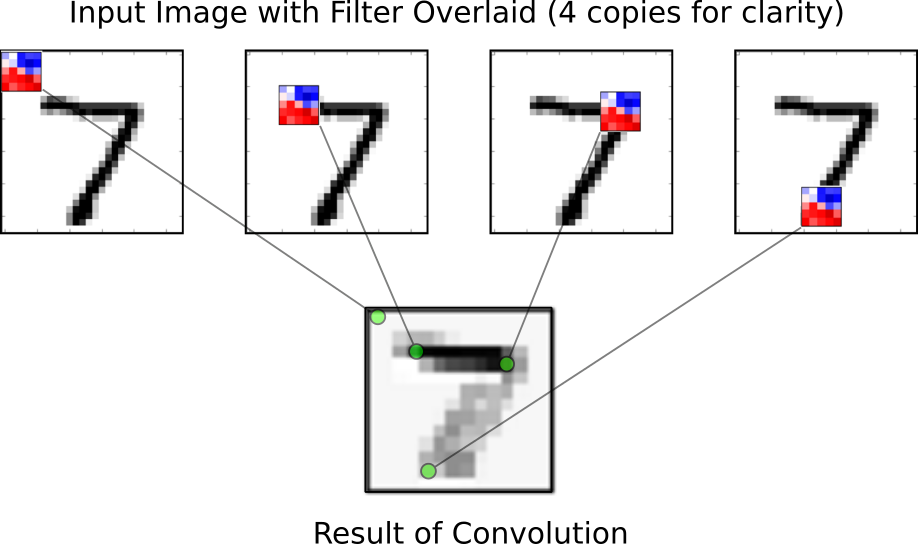

In [2]:
Image('figs/02_convolution.png')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import sys
sys.path.append('../')

##### Define configuration of Neural Network
Define 2 convlutional layers + a fully connected layer

In [4]:
filter_size1 = 5
num_filters1 = 16  # 16 filters

filter_size2 = 5
num_filters2 = 36 # 36 filters

fc_size = 128 
# number of neurons in fully-connected layer

##### Loading Data

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('../data/MNIST', one_hot = True)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


In [6]:
print('Size of:')
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Testing-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Testing-set:		10000
- Validation-set:		5000


In [7]:
data.test.cls = np.argmax(data.test.labels, axis = 1)
print(data.test.cls[0:20])

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


##### Define image dimensions

In [8]:
img_size = 28
img_size_flat = img_size**2
img_shape = (img_size, img_size)
num_channels = 1  ## Since it is in gray scale
num_classes = 10

In [44]:
def plotImages(imgs, cls, cls_pred = None):
    assert len(imgs) == len(cls) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i].reshape(img_shape), cmap = 'binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

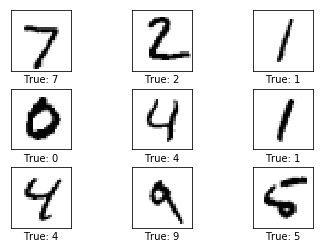

In [10]:
imgs = data.test.images[0:9]
cls = data.test.cls[0:9]
plotImages(imgs, cls)

##### Computational Graph
Define intermediate functions for creating new variables

In [11]:
 def new_weights(shape):
        return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))

In [12]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

##### Functions to define new convolutional layer
###### It is assumed that the input is a 4-dim tensor with the following dimensions:
1. Image number.
2. X-axis of each image.
3. Y-axis of each image.
4. Channels of each image.
###### strides determines how much the window shifts by in each of the dimensions. The typical use sets the first (the batch) and last (the depth) stride to 1.
###### If the input tensor has 4 dimensions:  [batch, height, width, channels], then the convolution operates on a 2D window on the height, width dimensions.

In [13]:
def new_conv_layer(input, num_input_channels, 
                   filter_size, num_filters,
                   use_pooling = True):
    shape = [filter_size, filter_size, 
             num_input_channels, num_filters]
    weights = new_weights(shape = shape)
    biases = new_biases(length = num_filters)
    '''Create the Tensorflow operation for convlutions'''
    ### use zero padding
    layer = tf.nn.conv2d(input = input, filter = weights,
                        strides = [1, 1, 1, 1], padding='SAME')
    layer += biases
    
    '''Whether use pulling to down-sample the image resolutions?'''
    if use_pooling:
        # This is 2X2 max-pooling, which means that we
        # consider 2X2 windows and select the largest value
        # in each window. The we move 2 pixels to the next
        layer = tf.nn.max_pool(value = layer, ksize = [1, 2, 2, 1],
                              strides = [1, 2, 2, 1], padding = 'SAME')
        # Rectified Linear Unit (ReLU)
        # It calculates max(x,0) for each input pixel s.
        # This adds some non-linearity to the formula and allows
        # to learn more complicated functions.
        layer = tf.nn.relu(layer)
        # Note that ReLU is normally executed before the pooling,
        # but since relu(max_pool(x)) == max_pool(relu(x)) we can
        # save 75% of the relu-operations by max-pooling first.
        
        return layer, weights

###### Function for flattening a layer (build the fully connected layer)

In [14]:
def flattenLayer(layer):
    layer_shape = layer.get_shape()
    # The shape of the input layer is assumed to be
    # layer_shape = [num_images, img_height, img_width, num_channels]
    # The number of features is: img_width*img_height*num_channels
    # The shape uses a Tensorflow datatype, so convert it to numpy
    num_features = np.array(layer_shape[1:4], dtype=int).prod()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])
    # The new shape should be compatible with the original shape. 
    # If an integer, then the result will be a 1-D array of that 
    # length. One shape dimension can be -1. In this case, 
    # the value is inferred from the length of the array and 
    # remaining dimensions.

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

##### Creating a fully connected layer

In [15]:
def new_fc_layer(input, # output of the previous layer
                num_input,
                num_output,
                use_relu = True):
    weights = new_weights(shape = [num_input, num_output])
    biases = new_biases(length = num_output)
    
    layer = tf.matmul(input, weights) + biases
    
    if(use_relu):
        layer = tf.nn.relu(layer)
        
    return layer

###### Placeholder variables

In [16]:
x = tf.placeholder(tf.float32, 
                   shape = [None, img_size_flat],
                  name = 'x')
x_image = tf.reshape(x, [-1,img_size, img_size, num_channels])
'''Since we are going to input it into the convolutional layers'''
y_true = tf.placeholder(tf.float32, 
                        shape = [None, 10],
                       name = 'y_true')
y_true_cls = tf.argmax(y_true, axis = 1)

##### Constructing the model:
###### Convolutional layer1

In [17]:
layer_conv1, weights_conv1 = new_conv_layer(
    input = x_image, num_input_channels = num_channels,
filter_size = filter_size1, num_filters = num_filters1,
use_pooling = True)

In [18]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

###### Convolutional layer2

In [19]:
layer_conv2, weights_conv2 = new_conv_layer(
input = layer_conv1, num_input_channels = num_filters1,
filter_size = filter_size2, num_filters = num_filters2,
use_pooling = True)

In [20]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

##### Flatten Layer

In [21]:
layer_flat, num_features = flattenLayer(layer_conv2)

In [22]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [23]:
num_features

1764

##### Creating a fully-connected layers
###### Fully-connected layer1

In [24]:
layer_fc1 = new_fc_layer(input=layer_flat,
                        num_input = num_features,
                        num_output = fc_size,
                        use_relu = True)

In [25]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

###### Fully-connected layer2

In [26]:
layer_fc2 = new_fc_layer(input = layer_fc1,
                        num_input = fc_size,
                        num_output = num_classes,
                        use_relu = False)

In [27]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

##### Prediced Class

In [28]:
y_pred = tf.nn.softmax(layer_fc2)

In [29]:
y_pred_cls = tf.argmax(y_pred, axis = 1)

In [30]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
logits = layer_fc2, labels = y_true)

In [31]:
cost = tf.reduce_mean(cross_entropy)

In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate =
                                   1e-4).minimize(cost)

In [33]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [34]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

##### TensorFlow Run

In [35]:
session = tf.Session()

In [36]:
session.run(tf.global_variables_initializer())

In [37]:
train_batch_size = 64

In [38]:
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    
    start_time = time.time()
    for i in range(total_iterations, total_iterations + num_iterations):
        # Get a batch of training examples
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        # set the batches as the training set
        train_set = {
            x: x_batch,
            y_true: y_true_batch,
        }
        session.run(optimizer, feed_dict = train_set)
        if i%100 == 0:
            # Calculate the accuracy on the train-set
            acc = session.run(accuracy, feed_dict = train_set)
            
            # Message for printing
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i+1, acc))
        # Update the total number of iterations performed
    total_iterations += num_iterations
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [45]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plotImages(imgs=images[0:9],
                cls=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [40]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [46]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [42]:
print_test_accuracy()

Accuracy on Test-Set: 11.3% (1134 / 10000)


Time usage: 0:00:00
Accuracy on Test-Set: 10.7% (1067 / 10000)
Example errors:


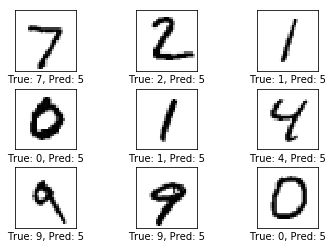

In [47]:
optimize(num_iterations=1)
print_test_accuracy(show_example_errors=True)

Optimization Iteration:    101, Training Accuracy:  76.6%
Time usage: 0:00:09
Accuracy on Test-Set: 70.2% (7018 / 10000)
Example errors:


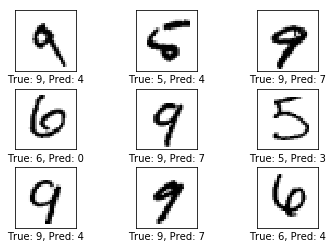

In [48]:
optimize(num_iterations=99)
print_test_accuracy(show_example_errors=True)

Optimization Iteration:    201, Training Accuracy:  85.9%
Optimization Iteration:    301, Training Accuracy:  89.1%
Optimization Iteration:    401, Training Accuracy:  93.8%
Optimization Iteration:    501, Training Accuracy:  89.1%
Optimization Iteration:    601, Training Accuracy:  92.2%
Optimization Iteration:    701, Training Accuracy:  92.2%
Optimization Iteration:    801, Training Accuracy:  90.6%
Optimization Iteration:    901, Training Accuracy:  89.1%
Optimization Iteration:   1001, Training Accuracy:  95.3%
Time usage: 0:01:25
Accuracy on Test-Set: 93.1% (9314 / 10000)
Example errors:


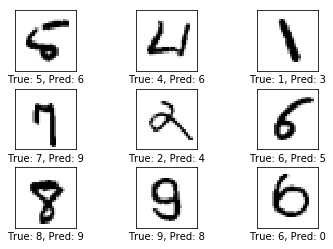

In [49]:
optimize(num_iterations=900)
print_test_accuracy(show_example_errors=True)

Optimization Iteration:   1101, Training Accuracy:  98.4%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  92.2%
Optimization Iteration:   1401, Training Accuracy:  90.6%
Optimization Iteration:   1501, Training Accuracy:  90.6%
Optimization Iteration:   1601, Training Accuracy:  90.6%
Optimization Iteration:   1701, Training Accuracy:  90.6%
Optimization Iteration:   1801, Training Accuracy:  95.3%
Optimization Iteration:   1901, Training Accuracy:  92.2%
Optimization Iteration:   2001, Training Accuracy:  95.3%
Optimization Iteration:   2101, Training Accuracy: 100.0%
Optimization Iteration:   2201, Training Accuracy:  95.3%
Optimization Iteration:   2301, Training Accuracy:  92.2%
Optimization Iteration:   2401, Training Accuracy:  96.9%
Optimization Iteration:   2501, Training Accuracy:  92.2%
Optimization Iteration:   2601, Training Accuracy:  90.6%
Optimization Iteration:   2701, Training Accuracy:  98.4%
Optimization I

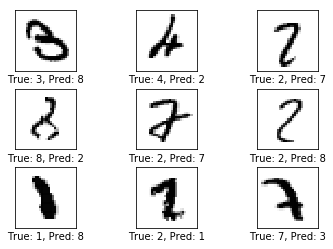

In [50]:
optimize(num_iterations=9000)
print_test_accuracy(show_example_errors=True)

Accuracy on Test-Set: 98.9% (9886 / 10000)
Example errors:


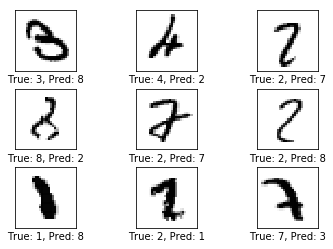

Confusion Matrix:
[[ 969    0    1    0    0    1    4    1    4    0]
 [   0 1129    2    0    0    0    1    1    2    0]
 [   1    1 1019    0    1    0    0    3    7    0]
 [   0    0    1  998    0    3    0    3    5    0]
 [   0    0    1    0  976    0    1    0    0    4]
 [   2    0    0    5    0  882    2    0    1    0]
 [   1    2    0    0    2    2  950    0    1    0]
 [   0    1    7    1    0    0    0 1016    1    2]
 [   2    0    2    2    1    1    0    2  962    2]
 [   1    5    0    1    7    3    0    5    2  985]]


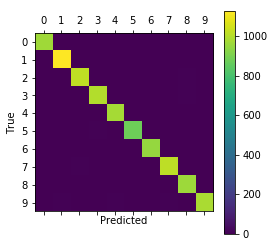

In [51]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [52]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [53]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [54]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

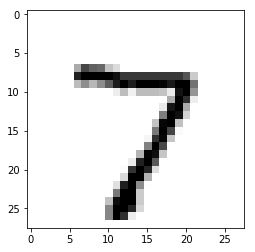

In [55]:
image1 = data.test.images[0]
plot_image(image1)

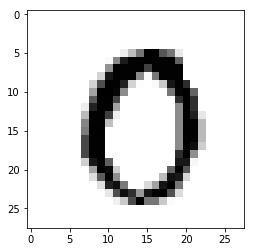

In [56]:
image2 = data.test.images[13]
plot_image(image2)


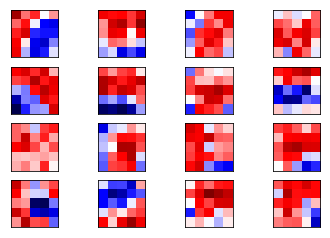

In [57]:
plot_conv_weights(weights=weights_conv1)

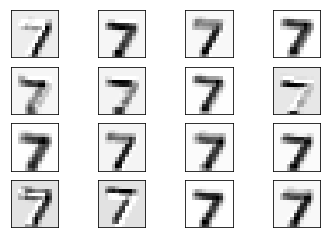

In [58]:
plot_conv_layer(layer=layer_conv1, image=image1)

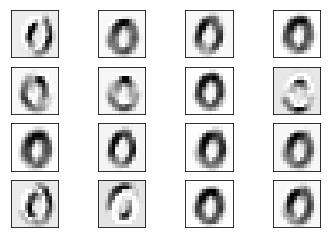

In [59]:
plot_conv_layer(layer=layer_conv1, image=image2)

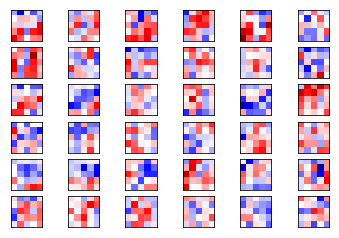

In [60]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

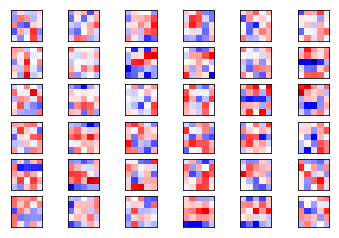

In [61]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

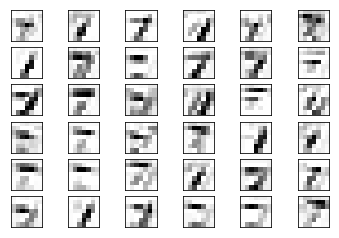

In [62]:
plot_conv_layer(layer=layer_conv2, image=image1)

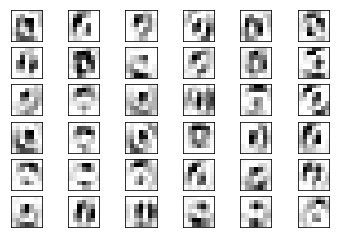

In [63]:
plot_conv_layer(layer=layer_conv2, image=image2)